In [1]:
# Step 1: Setup and Dependencies
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check if required packages are available
def check_dependencies():
    """Check if all required packages are installed"""
    required_packages = {
        'torch': torch.__version__,
        'torchvision': 'available',
        'ultralytics': 'available',
        'opencv-python': cv2.__version__,
        'PIL': 'available',
        'sklearn': 'available',
        'matplotlib': 'available'
    }

    print("Checking dependencies:")
    for package, version in required_packages.items():
        print(f"✓ {package}: {version}")

    # Check CUDA availability
    if torch.cuda.is_available():
        print(f"✓ CUDA available: {torch.cuda.get_device_name(0)}")
        print(f"✓ CUDA version: {torch.version.cuda}")
    else:
        print("⚠ CUDA not available, will use CPU")

    return True

# Configuration
class Config:
    """Configuration class for the project"""
    def __init__(self):
        # Model parameters
        self.model_size = 's'  # YOLOv8 size: 'n', 's', 'm', 'l', 'x'
        self.img_size = 640
        self.num_classes = 8  # KITTI classes

        # Training parameters
        self.batch_size = 16
        self.learning_rate = 1e-4
        self.num_epochs = 30
        self.patience = 5

        # Loss weights
        self.det_weight = 1.0
        self.dist_weight = 2.0

        # Dataset parameters
        self.max_images = 1000  # Limit for faster prototyping
        self.test_size = 0.2
        self.random_state = 42

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # KITTI class mapping
        self.kitti_to_yolo = {
            'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3,
            'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7
        }

    def __repr__(self):
        return f"Config(model_size={self.model_size}, batch_size={self.batch_size}, device={self.device})"

# Initialize configuration
config = Config()

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 1: Setup")
    print("=" * 50)

    # Check dependencies
    check_dependencies()

    print(f"\nConfiguration:")
    print(config)

    print("\n✓ Step 1 completed successfully!")
    print("Next: Run this to verify everything works, then we'll proceed to data loading.")

YOLOv8 Distance Estimation - Step 1: Setup
Checking dependencies:
✓ torch: 2.6.0+cu124
✓ torchvision: available
✓ ultralytics: available
✓ opencv-python: 4.11.0
✓ PIL: available
✓ sklearn: available
✓ matplotlib: available
✓ CUDA available: NVIDIA A100-SXM4-40GB
✓ CUDA version: 12.4

Configuration:
Config(model_size=s, batch_size=16, device=cuda)

✓ Step 1 completed successfully!
Next: Run this to verify everything works, then we'll proceed to data loading.


In [2]:
# Step 2: Dataset Setup and Data Loading
import kagglehub

def download_kitti_dataset():
    """Download KITTI dataset from Kaggle"""
    print("Downloading KITTI dataset...")
    try:
        path = kagglehub.dataset_download("klemenko/kitti-dataset")
        print(f"✓ Dataset downloaded to: {path}")
        return path
    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        print("Please ensure you have kaggle credentials set up.")
        return None

def setup_data_paths(dataset_path):
    """Setup and validate data paths"""
    if not dataset_path or not os.path.exists(dataset_path):
        raise ValueError("Invalid dataset path")

    paths = {
        'label_dir': os.path.join(dataset_path, "data_object_label_2/training/label_2"),
        'image_dir': os.path.join(dataset_path, "data_object_image_2/training/image_2"),
        'right_img_dir': os.path.join(dataset_path, "data_object_image_3/training/image_3"),
        'calib_dir': os.path.join(dataset_path, "data_object_calib/training/calib")
    }

    # Validate all paths exist
    for name, path in paths.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path not found: {name} -> {path}")
        print(f"✓ {name}: {len(os.listdir(path))} files")

    return paths

def explore_data_structure(paths):
    """Explore the structure of KITTI data"""
    print("\nData Structure Exploration:")
    print("=" * 30)

    # Sample files
    for name, path in paths.items():
        files = os.listdir(path)[:5]
        print(f"{name} samples: {files}")

    # Check file consistency
    image_files = set(os.listdir(paths['image_dir']))
    label_files = set(f.replace('.txt', '.png') for f in os.listdir(paths['label_dir']))
    calib_files = set(f.replace('.txt', '.png') for f in os.listdir(paths['calib_dir']))
    right_files = set(os.listdir(paths['right_img_dir']))

    common_files = image_files & label_files & calib_files & right_files
    print(f"\nFile consistency check:")
    print(f"Left images: {len(image_files)}")
    print(f"Labels: {len(label_files)}")
    print(f"Calibration: {len(calib_files)}")
    print(f"Right images: {len(right_files)}")
    print(f"Common files: {len(common_files)}")

    return sorted(list(common_files))

def load_calib_P2_baseline(calib_file):
    """Load calibration parameters for stereo vision"""
    try:
        with open(calib_file, "r") as f:
            lines = f.readlines()

        # Find P2 and P3 projection matrices
        P2_line = next((l for l in lines if l.startswith("P2")), None)
        P3_line = next((l for l in lines if l.startswith("P3")), None)

        if not P2_line or not P3_line:
            raise ValueError("P2 or P3 not found in calibration file")

        P2 = np.array([float(x) for x in P2_line.split()[1:]]).reshape(3, 4)
        P3 = np.array([float(x) for x in P3_line.split()[1:]]).reshape(3, 4)

        # Calculate focal length and baseline
        fx = P2[0, 0]
        baseline = abs((P2[0, 3] - P3[0, 3]) / fx)

        return fx, baseline
    except Exception as e:
        print(f"Error loading calibration from {calib_file}: {e}")
        return None, None

def test_stereo_depth_calculation(paths, common_files, num_test=3):
    """Test stereo depth calculation on a few samples"""
    print(f"\nTesting stereo depth calculation on {num_test} samples:")
    print("=" * 50)

    # Initialize stereo matcher
    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)

    successful_tests = 0

    for i, fname in enumerate(common_files[:num_test]):
        print(f"\nTest {i+1}: {fname}")

        # File paths
        left_path = os.path.join(paths['image_dir'], fname)
        right_path = os.path.join(paths['right_img_dir'], fname)
        calib_path = os.path.join(paths['calib_dir'], fname.replace(".png", ".txt"))

        try:
            # Load images
            imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
            imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

            if imgL is None or imgR is None:
                print(f"  ❌ Failed to load images")
                continue

            print(f"  ✓ Images loaded: {imgL.shape}")

            # Load calibration
            fx, baseline = load_calib_P2_baseline(calib_path)
            if fx is None:
                print(f"  ❌ Failed to load calibration")
                continue

            print(f"  ✓ Calibration: fx={fx:.1f}, baseline={baseline:.3f}m")

            # Compute disparity
            disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
            disparity[disparity <= 0.1] = 0.1

            # Convert to depth
            depth_map = (fx * baseline) / disparity
            depth_map = np.clip(depth_map, 0, 80)

            # Calculate median depth from center region
            h, w = depth_map.shape
            center_crop = depth_map[h//3:h*2//3, w//3:w*2//3]
            median_depth = np.median(center_crop)

            print(f"  ✓ Depth calculated: median={median_depth:.2f}m")
            print(f"    Depth range: {np.min(depth_map):.1f} - {np.max(depth_map):.1f}m")

            successful_tests += 1

        except Exception as e:
            print(f"  ❌ Error: {e}")

    print(f"\nStereo test results: {successful_tests}/{num_test} successful")
    return successful_tests > 0

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 2: Dataset Setup")
    print("=" * 55)

    # Download dataset
    dataset_path = download_kitti_dataset()
    if not dataset_path:
        print("❌ Failed to download dataset. Please check your Kaggle setup.")
        exit(1)

    # Setup paths
    try:
        paths = setup_data_paths(dataset_path)
        print("✓ All data paths validated")
    except Exception as e:
        print(f"❌ Path setup failed: {e}")
        exit(1)

    # Explore data
    common_files = explore_data_structure(paths)
    print(f"✓ Found {len(common_files)} complete data samples")

    # Test stereo depth calculation
    if test_stereo_depth_calculation(paths, common_files):
        print("\n✓ Step 2 completed successfully!")
        print("✓ Dataset is ready for depth label generation")
        print(f"✓ Will process {min(len(common_files), config.max_images)} images")
    else:
        print("\n❌ Stereo depth calculation failed")
        print("Please check the dataset integrity")

YOLOv8 Distance Estimation - Step 2: Dataset Setup
✓ Dataset downloaded to: /kaggle/input/kitti-dataset
✓ label_dir: 7481 files
✓ image_dir: 7481 files
✓ right_img_dir: 7481 files
✓ calib_dir: 7481 files
✓ All data paths validated

Data Structure Exploration:
label_dir samples: ['005063.txt', '000637.txt', '002604.txt', '004229.txt', '000360.txt']
image_dir samples: ['005084.png', '003065.png', '003741.png', '004725.png', '001183.png']
right_img_dir samples: ['005084.png', '003065.png', '003741.png', '004725.png', '001183.png']
calib_dir samples: ['005063.txt', '000637.txt', '002604.txt', '004229.txt', '000360.txt']

File consistency check:
Left images: 7481
Labels: 7481
Calibration: 7481
Right images: 7481
Common files: 7481
✓ Found 7481 complete data samples

Testing stereo depth calculation on 3 samples:

Test 1: 000000.png
  ✓ Images loaded: (370, 1224)
  ✓ Calibration: fx=707.0, baseline=0.537m
  ✓ Depth calculated: median=15.19m
    Depth range: 6.0 - 80.0m

Test 2: 000001.png
  

YOLOv8 Distance Estimation - Step 3: Depth Label Generation
Loading existing depth labels from kitti_depth_labels.pkl
✓ Loaded 1000 existing depth labels
✓ Successfully generated 1000 depth labels

Depth Distribution Analysis:
Count: 1000
Mean: 57.97m
Median: 60.89m
Std: 21.37m
Min: 11.41m
Max: 80.00m

Percentiles:
  10th: 27.82m
  25th: 39.97m
  50th: 60.89m
  75th: 80.00m
  90th: 80.00m


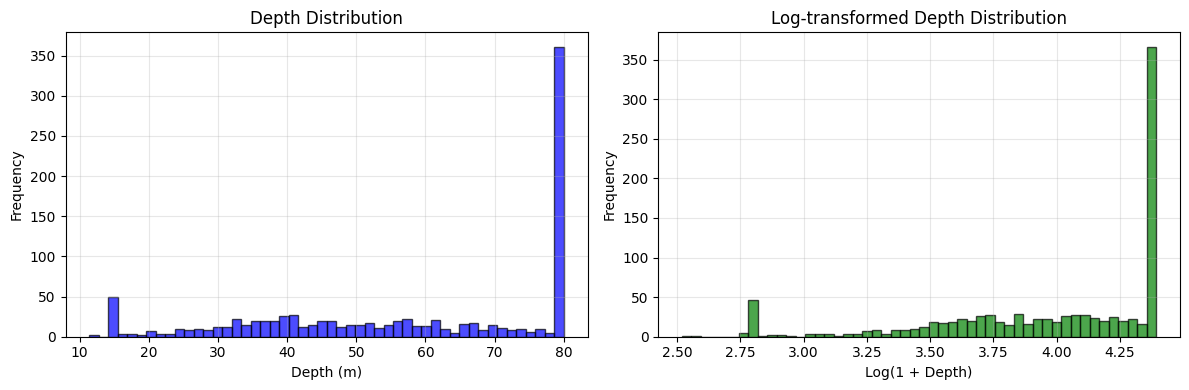


Verifying depth labels with 3 samples:
✓ 000000.png: 15.19m
✓ 000001.png: 80.00m
✓ 000002.png: 36.39m


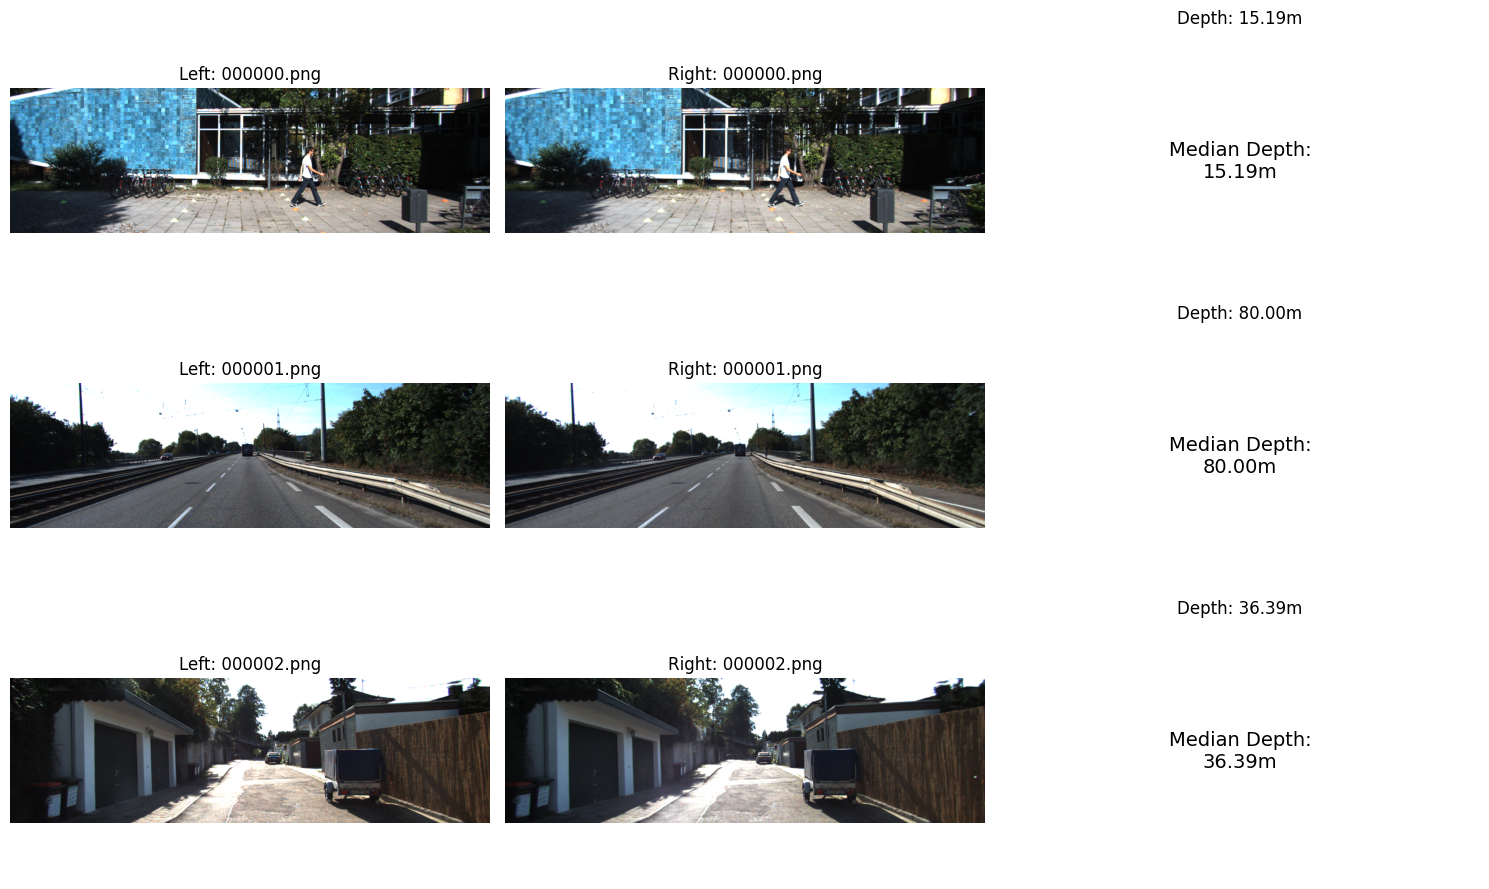


✓ Step 3 completed successfully!
✓ Depth labels are ready for training
✓ Next: Create custom dataset class and data loaders


In [3]:
# Step 3: Depth Label Generation
import pickle
import json
from pathlib import Path

def generate_depth_labels_batch(paths, common_files, max_images=1000, save_path="depth_labels.pkl"):
    """
    Generate depth labels for a batch of images using stereo vision

    Args:
        paths: Dictionary of data paths
        common_files: List of common image files
        max_images: Maximum number of images to process
        save_path: Path to save generated labels

    Returns:
        Dictionary mapping filename to median depth
    """

    # Check if labels already exist
    if os.path.exists(save_path):
        print(f"Loading existing depth labels from {save_path}")
        try:
            with open(save_path, 'rb') as f:
                depth_labels = pickle.load(f)
            print(f"✓ Loaded {len(depth_labels)} existing depth labels")
            return depth_labels
        except Exception as e:
            print(f"⚠ Error loading existing labels: {e}")
            print("Generating new labels...")

    print(f"Generating depth labels for {min(max_images, len(common_files))} images...")

    # Initialize stereo matcher with optimized parameters
    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)

    depth_labels = {}
    failed_images = []
    processing_stats = {
        'total_processed': 0,
        'successful': 0,
        'failed': 0,
        'avg_depth': 0
    }

    # Process images
    files_to_process = common_files[:max_images]

    for i, fname in enumerate(tqdm(files_to_process, desc="Generating depth labels")):
        try:
            # File paths
            left_path = os.path.join(paths['image_dir'], fname)
            right_path = os.path.join(paths['right_img_dir'], fname)
            calib_path = os.path.join(paths['calib_dir'], fname.replace(".png", ".txt"))

            # Load images
            imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
            imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

            if imgL is None or imgR is None:
                failed_images.append((fname, "Failed to load images"))
                processing_stats['failed'] += 1
                continue

            # Load calibration
            fx, baseline = load_calib_P2_baseline(calib_path)
            if fx is None or baseline is None:
                failed_images.append((fname, "Failed to load calibration"))
                processing_stats['failed'] += 1
                continue

            # Compute disparity
            disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

            # Handle invalid disparities
            disparity[disparity <= 0.1] = 0.1

            # Convert disparity to depth
            depth_map = (fx * baseline) / disparity
            depth_map = np.clip(depth_map, 0, 80)  # Clip to reasonable range

            # Extract median depth from center region
            h, w = depth_map.shape
            center_crop = depth_map[h//3:h*2//3, w//3:w*2//3]  # Fixed the bug here
            median_depth = np.median(center_crop)

            # Sanity check
            if median_depth <= 0 or median_depth > 80:
                failed_images.append((fname, f"Invalid depth: {median_depth}"))
                processing_stats['failed'] += 1
                continue

            depth_labels[fname] = median_depth
            processing_stats['successful'] += 1

        except Exception as e:
            failed_images.append((fname, str(e)))
            processing_stats['failed'] += 1

        processing_stats['total_processed'] += 1

        # Save intermediate results every 100 images
        if (i + 1) % 100 == 0:
            temp_save_path = f"temp_{save_path}"
            with open(temp_save_path, 'wb') as f:
                pickle.dump(depth_labels, f)

    # Calculate statistics
    if depth_labels:
        depths = list(depth_labels.values())
        processing_stats['avg_depth'] = np.mean(depths)
        processing_stats['min_depth'] = np.min(depths)
        processing_stats['max_depth'] = np.max(depths)
        processing_stats['std_depth'] = np.std(depths)

    # Save final results
    try:
        with open(save_path, 'wb') as f:
            pickle.dump(depth_labels, f)
        print(f"✓ Saved depth labels to {save_path}")
    except Exception as e:
        print(f"⚠ Failed to save depth labels: {e}")

    # Print summary
    print(f"\nDepth Label Generation Summary:")
    print(f"=" * 35)
    print(f"Total processed: {processing_stats['total_processed']}")
    print(f"Successful: {processing_stats['successful']}")
    print(f"Failed: {processing_stats['failed']}")

    if depth_labels:
        print(f"Average depth: {processing_stats['avg_depth']:.2f}m")
        print(f"Depth range: {processing_stats['min_depth']:.2f}m - {processing_stats['max_depth']:.2f}m")
        print(f"Depth std: {processing_stats['std_depth']:.2f}m")

    # Show some failed examples
    if failed_images:
        print(f"\nFailed images (showing first 5):")
        for fname, reason in failed_images[:5]:
            print(f"  {fname}: {reason}")

    return depth_labels

def analyze_depth_distribution(depth_labels):
    """Analyze the distribution of depth labels"""
    if not depth_labels:
        print("No depth labels to analyze")
        return

    depths = np.array(list(depth_labels.values()))

    print(f"\nDepth Distribution Analysis:")
    print(f"=" * 30)
    print(f"Count: {len(depths)}")
    print(f"Mean: {np.mean(depths):.2f}m")
    print(f"Median: {np.median(depths):.2f}m")
    print(f"Std: {np.std(depths):.2f}m")
    print(f"Min: {np.min(depths):.2f}m")
    print(f"Max: {np.max(depths):.2f}m")

    # Percentiles
    percentiles = [10, 25, 50, 75, 90]
    print(f"\nPercentiles:")
    for p in percentiles:
        print(f"  {p}th: {np.percentile(depths, p):.2f}m")

    # Create histogram
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(depths, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Depth (m)')
    plt.ylabel('Frequency')
    plt.title('Depth Distribution')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(depths), bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Log(1 + Depth)')
    plt.ylabel('Frequency')
    plt.title('Log-transformed Depth Distribution')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return depths

def verify_depth_labels(depth_labels, paths, num_samples=5):
    """Verify generated depth labels by visualizing samples"""
    print(f"\nVerifying depth labels with {num_samples} samples:")
    print("=" * 45)

    sample_files = list(depth_labels.keys())[:num_samples]

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, fname in enumerate(sample_files):
        try:
            # Load images
            left_path = os.path.join(paths['image_dir'], fname)
            right_path = os.path.join(paths['right_img_dir'], fname)

            left_img = cv2.imread(left_path)
            right_img = cv2.imread(right_path)

            if left_img is None or right_img is None:
                continue

            # Convert BGR to RGB for matplotlib
            left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
            right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

            # Show images
            axes[i, 0].imshow(left_img)
            axes[i, 0].set_title(f'Left: {fname}')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(right_img)
            axes[i, 1].set_title(f'Right: {fname}')
            axes[i, 1].axis('off')

            # Show depth info
            depth = depth_labels[fname]
            axes[i, 2].text(0.5, 0.5, f'Median Depth:\n{depth:.2f}m',
                          ha='center', va='center', fontsize=14,
                          transform=axes[i, 2].transAxes)
            axes[i, 2].set_title(f'Depth: {depth:.2f}m')
            axes[i, 2].axis('off')

            print(f"✓ {fname}: {depth:.2f}m")

        except Exception as e:
            print(f"❌ Error verifying {fname}: {e}")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 3: Depth Label Generation")
    print("=" * 60)

    # Generate depth labels
    depth_labels = generate_depth_labels_batch(
        paths,
        common_files,
        max_images=config.max_images,
        save_path="kitti_depth_labels.pkl"
    )

    if depth_labels:
        print(f"✓ Successfully generated {len(depth_labels)} depth labels")

        # Analyze distribution
        depths = analyze_depth_distribution(depth_labels)

        # Verify with samples
        verify_depth_labels(depth_labels, paths, num_samples=3)

        print("\n✓ Step 3 completed successfully!")
        print("✓ Depth labels are ready for training")
        print(f"✓ Next: Create custom dataset class and data loaders")

    else:
        print("❌ Failed to generate depth labels")
        print("Please check the previous steps and data integrity")

In [4]:
# Step 4: Custom Dataset Class and Data Loaders

class KITTIYOLODataset(Dataset):
    """
    Custom Dataset class for KITTI with YOLO format labels and distance information
    """

    def __init__(self, image_dir, label_dir, depth_labels, img_size=640, transform=None, augment=False):
        """
        Args:
            image_dir: Directory containing images
            label_dir: Directory containing YOLO format label files
            depth_labels: Dictionary mapping filename to depth value
            img_size: Target image size for resizing
            transform: Optional image transforms
            augment: Whether to apply data augmentation
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.depth_labels = depth_labels
        self.img_size = img_size
        self.transform = transform
        self.augment = augment

        # Only include files that have depth labels
        self.files = [f for f in depth_labels.keys() if f in depth_labels]

        # KITTI to YOLO class mapping
        self.kitti_to_yolo = {
            'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3,
            'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7
        }

        print(f"Dataset initialized with {len(self.files)} samples")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        Returns:
            image: Preprocessed image tensor
            labels: YOLO format labels [class, x_center, y_center, width, height]
            distances: Object distances (log-transformed)
            global_depth: Global image depth (log-transformed)
        """
        fname = self.files[idx]
        img_path = os.path.join(self.image_dir, fname)
        label_path = os.path.join(self.label_dir, fname.replace('.png', '.txt'))

        try:
            # Load and preprocess image
            image = Image.open(img_path).convert("RGB")
            orig_w, orig_h = image.size

            # Resize image
            image = image.resize((self.img_size, self.img_size))

            # Load and parse KITTI labels
            labels, distances = self._parse_kitti_labels(label_path, orig_w, orig_h)

            # Apply transforms
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            # Convert to tensors
            if len(labels) > 0:
                labels = torch.tensor(labels, dtype=torch.float32)
                distances = torch.tensor(distances, dtype=torch.float32)
            else:
                labels = torch.zeros((0, 5), dtype=torch.float32)
                distances = torch.zeros((0,), dtype=torch.float32)

            # Global depth label (log-transformed)
            global_depth = torch.tensor(np.log1p(self.depth_labels[fname]), dtype=torch.float32)

            return image, labels, distances, global_depth

        except Exception as e:
            print(f"Error loading {fname}: {e}")
            # Return dummy data on error
            dummy_image = torch.zeros((3, self.img_size, self.img_size), dtype=torch.float32)
            dummy_labels = torch.zeros((0, 5), dtype=torch.float32)
            dummy_distances = torch.zeros((0,), dtype=torch.float32)
            dummy_global_depth = torch.tensor(0.0, dtype=torch.float32)

            return dummy_image, dummy_labels, dummy_distances, dummy_global_depth

    def _parse_kitti_labels(self, label_path, orig_w, orig_h):
        """Parse KITTI format labels and convert to YOLO format"""
        labels = []
        distances = []

        if not os.path.exists(label_path):
            return labels, distances

        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 15 or parts[0] == 'DontCare':
                        continue

                    # Get class index
                    if parts[0] not in self.kitti_to_yolo:
                        continue

                    class_idx = self.kitti_to_yolo[parts[0]]

                    # Parse bounding box coordinates
                    try:
                        x1, y1, x2, y2 = map(float, parts[4:8])

                        # Validate coordinates
                        if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0:
                            continue

                        # Convert KITTI bbox to YOLO format (normalized xywh)
                        x_center = ((x1 + x2) / 2) / orig_w
                        y_center = ((y1 + y2) / 2) / orig_h
                        width = (x2 - x1) / orig_w
                        height = (y2 - y1) / orig_h

                        # Validate normalized coordinates
                        if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and
                               0 < width <= 1 and 0 < height <= 1):
                            continue

                        # Get object distance (z coordinate) and validate
                        distance = float(parts[13])
                        if distance <= 0 or distance > 100:  # Reasonable distance range
                            continue

                        labels.append([class_idx, x_center, y_center, width, height])
                        distances.append(np.log1p(distance))  # Log transform

                    except (ValueError, IndexError) as e:
                        continue  # Skip malformed lines

        except Exception as e:
            print(f"Error parsing label file {label_path}: {e}")

        return labels, distances

def create_data_transforms(img_size=640, augment=False):
    """Create data transformation pipelines"""

    if augment:
        # Training transforms with augmentation
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        # Validation transforms (no augmentation)
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    return transform

def custom_collate_fn(batch):
    """
    Custom collate function to handle variable number of objects per image
    """
    images, labels, distances, global_depths = zip(*batch)

    # Stack images (all same size after resize)
    images = torch.stack(images, 0)

    # Stack global depths (scalar values)
    global_depths = torch.stack(global_depths, 0)

    # Handle variable-length labels and distances
    # Add batch index to labels for YOLO format
    batch_labels = []
    batch_distances = []

    for i, (label_tensor, dist_tensor) in enumerate(zip(labels, distances)):
        if len(label_tensor) > 0:
            # Add batch index as first column for YOLO format
            batch_idx = torch.full((len(label_tensor), 1), i, dtype=torch.float32)
            label_with_batch = torch.cat([batch_idx, label_tensor], dim=1)
            batch_labels.append(label_with_batch)
            batch_distances.append(dist_tensor)

    # Concatenate all labels and distances
    if batch_labels:
        batch_labels = torch.cat(batch_labels, 0)  # [N, 6] where N is total objects
        batch_distances = torch.cat(batch_distances, 0)  # [N]
    else:
        batch_labels = torch.zeros((0, 6), dtype=torch.float32)
        batch_distances = torch.zeros((0,), dtype=torch.float32)

    return images, batch_labels, batch_distances, global_depths

def create_datasets_and_loaders(paths, depth_labels, config):
    """Create train/validation datasets and data loaders"""

    print("Creating datasets and data loaders...")

    # Split data into train/validation
    all_files = list(depth_labels.keys())
    train_files, val_files = train_test_split(
        all_files,
        test_size=config.test_size,
        random_state=config.random_state
    )

    print(f"Data split: {len(train_files)} train, {len(val_files)} validation")

    # Create label subsets
    train_labels = {k: depth_labels[k] for k in train_files}
    val_labels = {k: depth_labels[k] for k in val_files}

    # Create transforms
    train_transform = create_data_transforms(config.img_size, augment=True)
    val_transform = create_data_transforms(config.img_size, augment=False)

    # Create datasets
    train_dataset = KITTIYOLODataset(
        image_dir=paths['image_dir'],
        label_dir=paths['label_dir'],
        depth_labels=train_labels,
        img_size=config.img_size,
        transform=train_transform,
        augment=True
    )

    val_dataset = KITTIYOLODataset(
        image_dir=paths['image_dir'],
        label_dir=paths['label_dir'],
        depth_labels=val_labels,
        img_size=config.img_size,
        transform=val_transform,
        augment=False
    )

    # Create data loaders with custom collate function
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True,
        drop_last=True,
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True,
        drop_last=False,
        collate_fn=custom_collate_fn
    )

    print(f"✓ Train loader: {len(train_loader)} batches")
    print(f"✓ Val loader: {len(val_loader)} batches")

    return train_dataset, val_dataset, train_loader, val_loader

def test_dataset_loading(train_loader, val_loader, num_batches=2):
    """Test dataset loading with sample batches"""

    print(f"\nTesting dataset loading with {num_batches} batches:")
    print("=" * 50)

    # Test train loader
    print("Testing train loader:")
    for i, (images, labels, distances, global_depths) in enumerate(train_loader):
        print(f"  Batch {i+1}:")
        print(f"    Images: {images.shape} ({images.dtype})")
        print(f"    Labels: {labels.shape} ({labels.dtype}) - Format: [batch_idx, class, x, y, w, h]")
        print(f"    Distances: {distances.shape} ({distances.dtype})")
        print(f"    Global depths: {global_depths.shape} ({global_depths.dtype})")

        # Check for valid data
        print(f"    Image range: [{images.min():.3f}, {images.max():.3f}]")
        if len(global_depths) > 0:
            print(f"    Global depth range: [{global_depths.min():.3f}, {global_depths.max():.3f}]")
        if len(labels) > 0:
            print(f"    Batch indices: {labels[:, 0].unique().tolist()}")
            print(f"    Object classes: {labels[:, 1].unique().tolist()}")
            print(f"    Object distances: [{distances.min():.3f}, {distances.max():.3f}]")
        else:
            print(f"    No objects in this batch")

        if i >= num_batches - 1:
            break

    # Test val loader
    print("\nTesting validation loader:")
    for i, (images, labels, distances, global_depths) in enumerate(val_loader):
        print(f"  Batch {i+1}:")
        print(f"    Images: {images.shape}")
        print(f"    Labels: {labels.shape}")
        print(f"    Global depths: {global_depths.shape}")

        if len(labels) > 0:
            print(f"    Objects per image: {[(labels[:, 0] == j).sum().item() for j in range(images.size(0))]}")

        if i >= num_batches - 1:
            break

    print("✓ Dataset loading test completed successfully!")

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 4: Dataset Class and Data Loaders")
    print("=" * 70)

    # Create datasets and loaders
    train_dataset, val_dataset, train_loader, val_loader = create_datasets_and_loaders(
        paths, depth_labels, config
    )

    # Test dataset loading
    test_dataset_loading(train_loader, val_loader, num_batches=2)

    print(f"\n✓ Step 4 completed successfully!")
    print(f"✓ Datasets created: {len(train_dataset)} train, {len(val_dataset)} val samples")
    print(f"✓ Data loaders ready for training")
    print(f"✓ Next: Create custom YOLOv8 model with distance regression")

YOLOv8 Distance Estimation - Step 4: Dataset Class and Data Loaders
Creating datasets and data loaders...
Data split: 800 train, 200 validation
Dataset initialized with 800 samples
Dataset initialized with 200 samples
✓ Train loader: 50 batches
✓ Val loader: 13 batches

Testing dataset loading with 2 batches:
Testing train loader:
  Batch 1:
    Images: torch.Size([16, 3, 640, 640]) (torch.float32)
    Labels: torch.Size([80, 6]) (torch.float32) - Format: [batch_idx, class, x, y, w, h]
    Distances: torch.Size([80]) (torch.float32)
    Global depths: torch.Size([16]) (torch.float32)
    Image range: [-2.118, 2.640]
    Global depth range: [3.639, 4.394]
    Batch indices: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
    Object classes: [0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0]
    Object distances: [0.978, 4.160]
  Batch 2:
    Images: torch.Size([16, 3, 640, 640]) (torch.float32)
    Labels: torch.Size([77, 6]) (torch.float32) - Format: [batch_idx,

In [7]:
# Step 5: Custom YOLOv8 Model with Distance Regression

class DistanceRegressionHead(nn.Module):
    """Distance regression head for multi-scale features"""

    def __init__(self, in_channels, hidden_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim // 2, 3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim // 2, 1, 1)  # Single distance output
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.conv3(x)  # [B, 1, H, W]
        return x

class YOLOv8Distance(nn.Module):
    """YOLOv8 model extended with distance regression"""

    def __init__(self, model_size='s', num_classes=8, pretrained=True):
        super().__init__()

        # Load base YOLOv8 model - avoid triggering validation
        print(f"Loading YOLOv8{model_size} model...")
        self.yolo_model = YOLO(f'yolov8{model_size}.pt' if pretrained else f'yolov8{model_size}.yaml')

        # Extract just the model without training configuration
        self.model = self.yolo_model.model

        # Disable any automatic dataset downloading
        if hasattr(self.yolo_model, 'trainer'):
            self.yolo_model.trainer = None

        # Find detection head
        self.detect_layer_idx = None
        for i, module in enumerate(self.model.model):
            if hasattr(module, 'nc'):  # Detection head
                self.detect_layer_idx = i
                print(f"  Detection head found at layer {i}! nc={module.nc}")
                break

        if self.detect_layer_idx is None:
            raise ValueError("Could not find YOLOv8 detection head")

        # Extract feature channels from key backbone layers for distance regression
        # We'll use features before the neck (FPN) part to avoid conflicts
        self.distance_feature_layers = [6, 8, 9]  # Layers with good feature representations
        self.feature_channels = self._extract_distance_channels()

        print(f"Found detection head at layer {self.detect_layer_idx}")
        print(f"Distance feature layers: {self.distance_feature_layers}")
        print(f"Distance feature channels: {self.feature_channels}")

        # Create distance regression heads for selected backbone features
        self.distance_heads = nn.ModuleList([
            DistanceRegressionHead(ch) for ch in self.feature_channels
        ])

        # Store original detection head
        self.detect_head = self.model.model[self.detect_layer_idx]
        self.num_classes = num_classes

        print(f"✓ YOLOv8{model_size} with distance regression initialized")
        print(f"✓ {len(self.distance_heads)} distance heads created")

    def _extract_distance_channels(self):
        """Extract feature channels from selected backbone layers"""
        print("Extracting distance feature channels...")

        # Set model to eval mode manually
        for module in self.model.modules():
            if hasattr(module, 'training'):
                module.training = False

        with torch.no_grad():
            # Create dummy input
            dummy_input = torch.randn(1, 3, 640, 640)
            features = []
            x = dummy_input

            try:
                # Run through backbone layers only
                for i, layer in enumerate(self.model.model):
                    if i >= self.detect_layer_idx:
                        break

                    # Handle different layer types
                    if hasattr(layer, 'f') and layer.f != -1:
                        if isinstance(layer.f, int):
                            if layer.f == -1:
                                x = layer(x)
                            else:
                                x = layer(features[layer.f])
                        elif isinstance(layer.f, list):
                            x = layer([features[j] if j != -1 else x for j in layer.f])
                    else:
                        x = layer(x)

                    features.append(x)
                    if i in self.distance_feature_layers:
                        print(f"  Distance feature layer {i}: {x.shape}")

                # Get channels from selected layers
                channels = [features[i].shape[1] for i in self.distance_feature_layers]
                return channels

            except Exception as e:
                print(f"Error during feature extraction: {e}")
                # Fallback to standard configuration
                print("Using fallback configuration")
                return [256, 512, 512]

    def forward(self, x):
        """
        Forward pass with both detection and distance outputs

        Returns:
            det_output: Detection predictions from original YOLO head
            dist_outputs: List of distance predictions from backbone features
        """
        features = []
        distance_features = []

        # Run through the full model, collecting features
        for i, layer in enumerate(self.model.model):

            # Handle different layer types
            if hasattr(layer, 'f') and layer.f != -1:
                if isinstance(layer.f, int):
                    if layer.f == -1:
                        x = layer(x)
                    else:
                        x = layer(features[layer.f])
                elif isinstance(layer.f, list):
                    x = layer([features[j] if j != -1 else x for j in layer.f])
            else:
                x = layer(x)

            features.append(x)

            # Collect distance features from selected backbone layers
            if i in self.distance_feature_layers:
                distance_features.append(x)

        # Apply distance regression heads to backbone features
        dist_outputs = []
        for feat, dist_head in zip(distance_features, self.distance_heads):
            dist_out = dist_head(feat)
            dist_outputs.append(dist_out)

        # The last feature is the output from detection head
        det_output = x

        return det_output, dist_outputs

    def to(self, device):
        """Override to method to handle YOLO model properly"""
        super().to(device)
        if hasattr(self.yolo_model, 'model'):
            self.yolo_model.model = self.yolo_model.model.to(device)
        return self

class YOLODistanceLoss(nn.Module):
    """Combined loss for detection and distance regression"""

    def __init__(self, det_weight=1.0, dist_weight=1.0, global_dist_weight=1.0):
        super().__init__()
        self.det_weight = det_weight
        self.dist_weight = dist_weight
        self.global_dist_weight = global_dist_weight

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()

        print(f"Loss weights - Detection: {det_weight}, Distance: {dist_weight}, Global: {global_dist_weight}")

    def forward(self, predictions, targets):
        """
        Args:
            predictions: tuple of (det_output, dist_outputs)
            targets: tuple of (det_labels, obj_distances, global_depths)
        """
        det_pred, dist_preds = predictions
        det_labels, obj_distances, global_depths = targets

        total_loss = 0.0
        loss_components = {}

        # Detection loss - simplified for now
        # In practice, you'd use YOLOv8's actual loss computation
        det_loss = torch.tensor(0.0, device=global_depths.device, requires_grad=True)
        loss_components['detection'] = det_loss.item()

        # Distance regression loss (global depth prediction)
        if dist_preds and len(dist_preds) > 0:
            # Aggregate predictions from all scales
            global_dist_preds = []

            for dist_pred in dist_preds:
                # Global average pooling to get single distance value per image
                B = dist_pred.size(0)
                dist_pooled = torch.mean(dist_pred.view(B, -1), dim=1)  # [B]
                global_dist_preds.append(dist_pooled)

            # Average predictions from all scales
            if global_dist_preds:
                avg_dist_pred = torch.stack(global_dist_preds).mean(dim=0)  # [B]

                # Compute loss against global depth labels
                global_dist_loss = self.smooth_l1_loss(avg_dist_pred, global_depths)
                loss_components['global_distance'] = global_dist_loss.item()

                total_loss += self.global_dist_weight * global_dist_loss
            else:
                loss_components['global_distance'] = 0.0
        else:
            loss_components['global_distance'] = 0.0

        # Add detection loss
        total_loss += self.det_weight * det_loss

        return total_loss, loss_components

def create_yolo_distance_model(config):
    """Create and initialize YOLOv8 distance model"""

    print(f"Creating YOLOv8{config.model_size} with distance regression...")

    try:
        # Create model
        model = YOLOv8Distance(
            model_size=config.model_size,
            num_classes=config.num_classes,
            pretrained=True
        )

        # Move to device
        model = model.to(config.device)

        # Create loss function
        criterion = YOLODistanceLoss(
            det_weight=config.det_weight,
            dist_weight=config.dist_weight,
            global_dist_weight=2.0  # Focus on global distance for now
        )

        # Create optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print("✓ Model created successfully")
        return model, criterion, optimizer, scheduler

    except Exception as e:
        print(f"❌ Error creating model: {e}")
        raise

def test_model_forward_pass(model, train_loader, device):
    """Test model forward pass with sample batch"""

    print("\nTesting model forward pass:")
    print("=" * 30)

    # Set model to eval mode without triggering YOLO's validation
    for module in model.modules():
        if hasattr(module, 'training'):
            module.training = False

    with torch.no_grad():
        # Get one batch
        images, labels, distances, global_depths = next(iter(train_loader))
        images = images.to(device)
        global_depths = global_depths.to(device)

        print(f"Input batch:")
        print(f"  Images: {images.shape}")
        print(f"  Global depths: {global_depths.shape}")

        try:
            # Forward pass
            det_output, dist_outputs = model(images)

            print(f"Model outputs:")
            print(f"  Detection output type: {type(det_output)}")

            # Handle different output types from YOLO
            if isinstance(det_output, (list, tuple)):
                print(f"  Detection outputs: {len(det_output)} tensors")
                for i, out in enumerate(det_output):
                    if hasattr(out, 'shape'):
                        print(f"    Output {i}: {out.shape}")
            elif hasattr(det_output, 'shape'):
                print(f"  Detection output shape: {det_output.shape}")

            print(f"  Distance outputs: {len(dist_outputs)} scales")
            for i, dist_out in enumerate(dist_outputs):
                print(f"    Scale {i}: {dist_out.shape}")

            # Test loss computation
            criterion = YOLODistanceLoss()
            loss, loss_components = criterion(
                (det_output, dist_outputs),
                (labels, distances, global_depths)
            )

            print(f"Loss computation:")
            print(f"  Total loss: {loss.item():.4f}")
            for name, value in loss_components.items():
                print(f"  {name}: {value:.4f}")

            print("✓ Forward pass successful!")
            return True

        except Exception as e:
            print(f"❌ Forward pass failed: {e}")
            import traceback
            traceback.print_exc()
            return False

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 5: Custom YOLOv8 Model")
    print("=" * 60)

    # Create model
    try:
        model, criterion, optimizer, scheduler = create_yolo_distance_model(config)

        # Test forward pass
        if test_model_forward_pass(model, train_loader, config.device):
            print(f"\n✓ Step 5 completed successfully!")
            print(f"✓ YOLOv8{config.model_size} with distance regression ready")
            print(f"✓ Model has {sum(p.numel() for p in model.parameters()):,} parameters")
            print(f"✓ Next: Training loop implementation")
        else:
            print(f"\n❌ Step 5 failed - model forward pass error")

    except Exception as e:
        print(f"❌ Step 5 failed: {e}")
        import traceback
        traceback.print_exc()

YOLOv8 Distance Estimation - Step 5: Custom YOLOv8 Model
Creating YOLOv8s with distance regression...
Loading YOLOv8s model...
  Detection head found at layer 22! nc=80
Extracting distance feature channels...
  Distance feature layer 6: torch.Size([1, 256, 40, 40])
  Distance feature layer 8: torch.Size([1, 512, 20, 20])
  Distance feature layer 9: torch.Size([1, 512, 20, 20])
Found detection head at layer 22
Distance feature layers: [6, 8, 9]
Distance feature channels: [256, 512, 512]
✓ YOLOv8s with distance regression initialized
✓ 3 distance heads created
Loss weights - Detection: 1.0, Distance: 2.0, Global: 2.0
✓ Model created successfully

Testing model forward pass:
Input batch:
  Images: torch.Size([16, 3, 640, 640])
  Global depths: torch.Size([16])
Model outputs:
  Detection output type: <class 'tuple'>
  Detection outputs: 2 tensors
    Output 0: torch.Size([16, 84, 8400])
  Distance outputs: 3 scales
    Scale 0: torch.Size([16, 1, 40, 40])
    Scale 1: torch.Size([16, 1, 20

YOLOv8 Distance Estimation - Step 6: Training Loop
Starting training...

Epoch 1/30
------------------------------


Epoch 1 - Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, Loss=0.1254, Global Dist=0.0627]


Train Loss: 1.6287 | Val Loss: 0.1254 | Time: 60.7s
RMSE: 18.98m | MAE: 16.07m | R²: 0.209
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 2/30
------------------------------


Epoch 2 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s, Loss=0.0745, Global Dist=0.0372]


Train Loss: 0.1146 | Val Loss: 0.0745 | Time: 57.2s
RMSE: 14.15m | MAE: 11.17m | R²: 0.560
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 3/30
------------------------------


Epoch 3 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, Loss=0.0658, Global Dist=0.0329]


Train Loss: 0.0866 | Val Loss: 0.0658 | Time: 57.1s
RMSE: 13.44m | MAE: 10.66m | R²: 0.604
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 4/30
------------------------------


Epoch 4 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, Loss=0.0625, Global Dist=0.0313]


Train Loss: 0.0874 | Val Loss: 0.0625 | Time: 57.0s
RMSE: 13.24m | MAE: 10.38m | R²: 0.615
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 5/30
------------------------------


Epoch 5 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.0577, Global Dist=0.0289]


Train Loss: 0.0762 | Val Loss: 0.0577 | Time: 56.8s
RMSE: 13.05m | MAE: 10.11m | R²: 0.626
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!
✓ Checkpoint saved: yolov8_distance_epoch_5.pth

Epoch 6/30
------------------------------


Epoch 6 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.0539, Global Dist=0.0269]


Train Loss: 0.0754 | Val Loss: 0.0539 | Time: 57.1s
RMSE: 12.62m | MAE: 9.89m | R²: 0.651
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 7/30
------------------------------


Epoch 7 - Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s, Loss=0.0539, Global Dist=0.0270]


Train Loss: 0.0657 | Val Loss: 0.0539 | Time: 56.1s
RMSE: 12.71m | MAE: 9.90m | R²: 0.646

Epoch 8/30
------------------------------


Epoch 8 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.0614, Global Dist=0.0307]


Train Loss: 0.0668 | Val Loss: 0.0614 | Time: 56.4s
RMSE: 14.60m | MAE: 11.27m | R²: 0.532

Epoch 9/30
------------------------------


Epoch 9 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s, Loss=0.0604, Global Dist=0.0302]


Train Loss: 0.0552 | Val Loss: 0.0604 | Time: 56.0s
RMSE: 13.36m | MAE: 10.39m | R²: 0.608

Epoch 10/30
------------------------------


Epoch 10 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0526, Global Dist=0.0263]


Train Loss: 0.0583 | Val Loss: 0.0526 | Time: 55.9s
RMSE: 12.83m | MAE: 9.91m | R²: 0.639
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!
✓ Checkpoint saved: yolov8_distance_epoch_10.pth

Epoch 11/30
------------------------------


Epoch 11 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0513, Global Dist=0.0257]


Train Loss: 0.0518 | Val Loss: 0.0513 | Time: 56.2s
RMSE: 12.60m | MAE: 9.79m | R²: 0.651
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 12/30
------------------------------


Epoch 12 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, Loss=0.0506, Global Dist=0.0253]


Train Loss: 0.0549 | Val Loss: 0.0506 | Time: 56.2s
RMSE: 12.58m | MAE: 9.82m | R²: 0.653
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 13/30
------------------------------


Epoch 13 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.0494, Global Dist=0.0247]


Train Loss: 0.0499 | Val Loss: 0.0494 | Time: 56.2s
RMSE: 12.34m | MAE: 9.74m | R²: 0.666
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 14/30
------------------------------


Epoch 14 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, Loss=0.0492, Global Dist=0.0246]


Train Loss: 0.0515 | Val Loss: 0.0492 | Time: 55.9s
RMSE: 12.26m | MAE: 9.59m | R²: 0.670
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 15/30
------------------------------


Epoch 15 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, Loss=0.0497, Global Dist=0.0248]


Train Loss: 0.0508 | Val Loss: 0.0497 | Time: 55.9s
RMSE: 12.45m | MAE: 9.79m | R²: 0.660
✓ Checkpoint saved: yolov8_distance_epoch_15.pth

Epoch 16/30
------------------------------


Epoch 16 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, Loss=0.0487, Global Dist=0.0243]


Train Loss: 0.0476 | Val Loss: 0.0487 | Time: 56.0s
RMSE: 12.17m | MAE: 9.60m | R²: 0.675
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 17/30
------------------------------


Epoch 17 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s, Loss=0.0488, Global Dist=0.0244]


Train Loss: 0.0475 | Val Loss: 0.0488 | Time: 55.9s
RMSE: 12.13m | MAE: 9.52m | R²: 0.677

Epoch 18/30
------------------------------


Epoch 18 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, Loss=0.0496, Global Dist=0.0248]


Train Loss: 0.0460 | Val Loss: 0.0496 | Time: 56.1s
RMSE: 12.13m | MAE: 9.50m | R²: 0.677

Epoch 19/30
------------------------------


Epoch 19 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.0483, Global Dist=0.0242]


Train Loss: 0.0439 | Val Loss: 0.0483 | Time: 56.1s
RMSE: 12.04m | MAE: 9.49m | R²: 0.682
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 20/30
------------------------------


Epoch 20 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0480, Global Dist=0.0240]


Train Loss: 0.0478 | Val Loss: 0.0480 | Time: 56.2s
RMSE: 12.03m | MAE: 9.47m | R²: 0.683
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!
✓ Checkpoint saved: yolov8_distance_epoch_20.pth

Epoch 21/30
------------------------------


Epoch 21 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, Loss=0.0480, Global Dist=0.0240]


Train Loss: 0.0462 | Val Loss: 0.0480 | Time: 57.2s
RMSE: 12.14m | MAE: 9.51m | R²: 0.677

Epoch 22/30
------------------------------


Epoch 22 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, Loss=0.0491, Global Dist=0.0245]


Train Loss: 0.0430 | Val Loss: 0.0491 | Time: 55.6s
RMSE: 12.44m | MAE: 9.78m | R²: 0.661

Epoch 23/30
------------------------------


Epoch 23 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, Loss=0.0493, Global Dist=0.0247]


Train Loss: 0.0473 | Val Loss: 0.0493 | Time: 55.7s
RMSE: 12.14m | MAE: 9.47m | R²: 0.676

Epoch 24/30
------------------------------


Epoch 24 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, Loss=0.0501, Global Dist=0.0251]


Train Loss: 0.0480 | Val Loss: 0.0501 | Time: 55.6s
RMSE: 12.26m | MAE: 9.52m | R²: 0.670

Epoch 25/30
------------------------------


Epoch 25 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, Loss=0.0478, Global Dist=0.0239]


Train Loss: 0.0435 | Val Loss: 0.0478 | Time: 55.5s
RMSE: 12.20m | MAE: 9.60m | R²: 0.673
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!
✓ Checkpoint saved: yolov8_distance_epoch_25.pth

Epoch 26/30
------------------------------


Epoch 26 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0478, Global Dist=0.0239]


Train Loss: 0.0425 | Val Loss: 0.0478 | Time: 55.6s
RMSE: 12.25m | MAE: 9.61m | R²: 0.671

Epoch 27/30
------------------------------


Epoch 27 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, Loss=0.0481, Global Dist=0.0240]


Train Loss: 0.0432 | Val Loss: 0.0481 | Time: 56.0s
RMSE: 12.29m | MAE: 9.63m | R²: 0.668

Epoch 28/30
------------------------------


Epoch 28 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0477, Global Dist=0.0238]


Train Loss: 0.0427 | Val Loss: 0.0477 | Time: 56.4s
RMSE: 11.99m | MAE: 9.39m | R²: 0.685
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 29/30
------------------------------


Epoch 29 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, Loss=0.0472, Global Dist=0.0236]


Train Loss: 0.0415 | Val Loss: 0.0472 | Time: 55.8s
RMSE: 12.06m | MAE: 9.44m | R²: 0.681
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!

Epoch 30/30
------------------------------


Epoch 30 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, Loss=0.0471, Global Dist=0.0235]


Train Loss: 0.0470 | Val Loss: 0.0471 | Time: 55.8s
RMSE: 12.03m | MAE: 9.47m | R²: 0.682
✓ Checkpoint saved: yolov8_distance_best.pth
✓ New best model saved!
✓ Checkpoint saved: yolov8_distance_epoch_30.pth


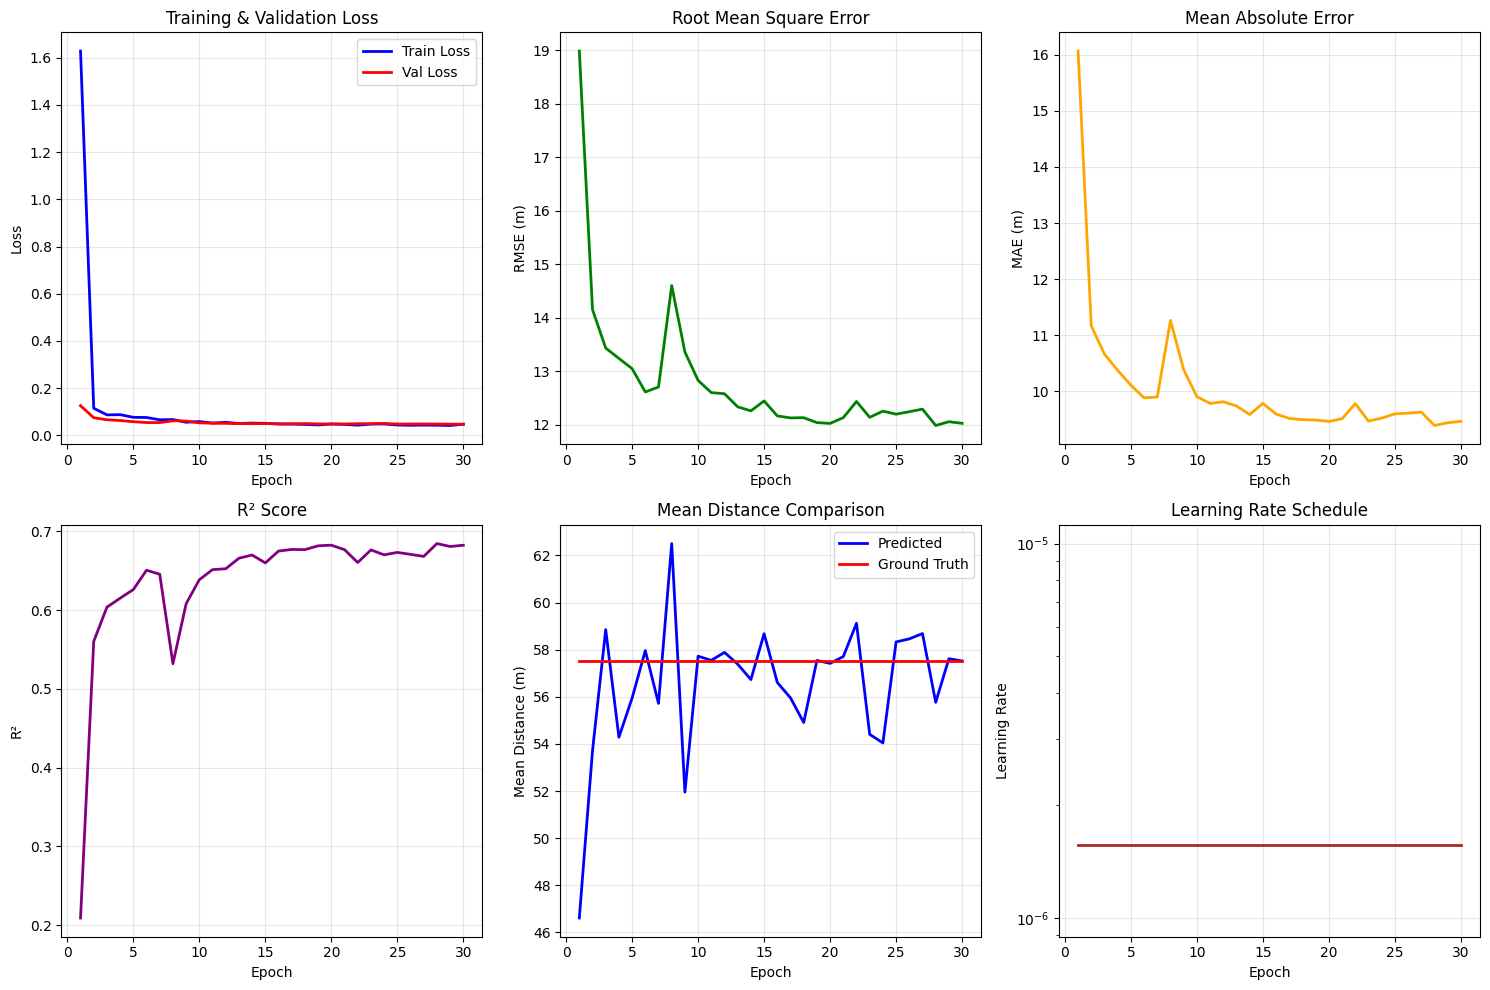


✓ Training completed!
✓ Best validation loss: 0.0471
✓ Total epochs: 30

✓ Step 6 completed successfully!
✓ Model trained for 30 epochs
✓ Best model saved as 'yolov8_distance_best.pth'
✓ Ready for inference and evaluation!


In [9]:
# Step 6: Training Loop Implementation

import time
from collections import defaultdict

def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    """Train one epoch"""

    # Set model to training mode manually (avoid YOLOv8's train method)
    set_model_mode(model, training=True)

    running_loss = 0.0
    running_components = defaultdict(float)
    num_batches = 0

    start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    for batch_idx, (images, labels, distances, global_depths) in enumerate(progress_bar):
        try:
            # Move to device
            images = images.to(device)
            global_depths = global_depths.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            det_output, dist_outputs = model(images)

            # Compute loss
            loss, loss_components = criterion(
                (det_output, dist_outputs),
                (labels, distances, global_depths)
            )

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

            # Update weights
            optimizer.step()

            # Update running statistics
            running_loss += loss.item()
            for name, value in loss_components.items():
                running_components[name] += value
            num_batches += 1

            # Update progress bar
            avg_loss = running_loss / num_batches
            progress_bar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Global Dist': f'{running_components["global_distance"]/num_batches:.4f}'
            })

        except Exception as e:
            print(f"Error in training batch {batch_idx}: {e}")
            continue

    # Calculate epoch statistics
    epoch_time = time.time() - start_time
    avg_loss = running_loss / max(num_batches, 1)
    avg_components = {name: value/max(num_batches, 1) for name, value in running_components.items()}

    return avg_loss, avg_components, epoch_time

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate one epoch"""

    # Set model to eval mode manually
    set_model_mode(model, training=False)

    running_loss = 0.0
    running_components = defaultdict(float)
    predictions = []
    ground_truths = []
    num_batches = 0

    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch_idx, (images, labels, distances, global_depths) in enumerate(progress_bar):
            try:
                # Move to device
                images = images.to(device)
                global_depths = global_depths.to(device)

                # Forward pass
                det_output, dist_outputs = model(images)

                # Compute loss
                loss, loss_components = criterion(
                    (det_output, dist_outputs),
                    (labels, distances, global_depths)
                )

                # Extract distance predictions for metrics
                if dist_outputs and len(dist_outputs) > 0:
                    # Average predictions from all scales
                    global_dist_preds = []
                    for dist_pred in dist_outputs:
                        B = dist_pred.size(0)
                        dist_pooled = torch.mean(dist_pred.view(B, -1), dim=1)
                        global_dist_preds.append(dist_pooled)

                    if global_dist_preds:
                        avg_dist_pred = torch.stack(global_dist_preds).mean(dim=0)
                        predictions.extend(avg_dist_pred.cpu().numpy())
                        ground_truths.extend(global_depths.cpu().numpy())

                # Update running statistics
                running_loss += loss.item()
                for name, value in loss_components.items():
                    running_components[name] += value
                num_batches += 1

                # Update progress bar
                avg_loss = running_loss / num_batches
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Global Dist': f'{running_components["global_distance"]/num_batches:.4f}'
                })

            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {e}")
                continue

    # Calculate metrics
    avg_loss = running_loss / max(num_batches, 1)
    avg_components = {name: value/max(num_batches, 1) for name, value in running_components.items()}

    # Calculate distance regression metrics
    metrics = {}
    if len(predictions) > 0:
        predictions = np.array(predictions)
        ground_truths = np.array(ground_truths)

        # Convert from log space back to real distances
        pred_distances = np.expm1(np.clip(predictions, 0, 5))
        true_distances = np.expm1(np.clip(ground_truths, 0, 5))

        # Calculate metrics
        metrics['rmse'] = mean_squared_error(true_distances, pred_distances) ** 0.5
        metrics['mae'] = mean_absolute_error(true_distances, pred_distances)
        metrics['r2'] = r2_score(true_distances, pred_distances)

        # Additional metrics
        metrics['mean_pred'] = np.mean(pred_distances)
        metrics['mean_true'] = np.mean(true_distances)
        metrics['std_pred'] = np.std(pred_distances)
        metrics['std_true'] = np.std(true_distances)

    return avg_loss, avg_components, metrics

def set_model_mode(model, training=True):
    """Manually set model training mode to avoid YOLOv8 conflicts"""

    # Set our custom distance heads
    for module in model.distance_heads:
        module.train(training)

    # Set the underlying YOLOv8 model components manually
    for module in model.model.modules():
        if hasattr(module, 'training'):
            module.training = training

    # Set our custom model
    if hasattr(model, 'training'):
        model.training = training

def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, metrics, save_path):
    """Save model checkpoint"""

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'metrics': metrics,
        'config': config.__dict__
    }

    torch.save(checkpoint, save_path)
    print(f"✓ Checkpoint saved: {save_path}")

def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """Load model checkpoint"""

    checkpoint = torch.load(checkpoint_path, map_location=config.device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print(f"✓ Checkpoint loaded: {checkpoint_path}")
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss'], checkpoint['metrics']

def plot_training_history(train_losses, val_losses, metrics_history):
    """Plot training history"""

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 10))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # RMSE plot
    if 'rmse' in metrics_history and len(metrics_history['rmse']) > 0:
        plt.subplot(2, 3, 2)
        plt.plot(epochs, metrics_history['rmse'], 'g-', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('RMSE (m)')
        plt.title('Root Mean Square Error')
        plt.grid(True, alpha=0.3)

    # MAE plot
    if 'mae' in metrics_history and len(metrics_history['mae']) > 0:
        plt.subplot(2, 3, 3)
        plt.plot(epochs, metrics_history['mae'], 'orange', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('MAE (m)')
        plt.title('Mean Absolute Error')
        plt.grid(True, alpha=0.3)

    # R² plot
    if 'r2' in metrics_history and len(metrics_history['r2']) > 0:
        plt.subplot(2, 3, 4)
        plt.plot(epochs, metrics_history['r2'], 'purple', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('R²')
        plt.title('R² Score')
        plt.grid(True, alpha=0.3)

    # Distance distribution comparison
    if 'mean_pred' in metrics_history and 'mean_true' in metrics_history:
        plt.subplot(2, 3, 5)
        plt.plot(epochs, metrics_history['mean_pred'], 'b-', label='Predicted', linewidth=2)
        plt.plot(epochs, metrics_history['mean_true'], 'r-', label='Ground Truth', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Distance (m)')
        plt.title('Mean Distance Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Learning rate plot (if available)
    plt.subplot(2, 3, 6)
    if hasattr(scheduler, 'get_last_lr'):
        lr_history = [scheduler.get_last_lr()[0] for _ in epochs]
        plt.plot(epochs, lr_history, 'brown', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config):
    """Main training loop"""

    print("Starting training...")
    print("=" * 50)

    # Training history
    train_losses = []
    val_losses = []
    metrics_history = defaultdict(list)

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print("-" * 30)

        # Train
        train_loss, train_components, train_time = train_epoch(
            model, train_loader, optimizer, criterion, config.device, epoch
        )

        # Validate
        val_loss, val_components, val_metrics = validate_epoch(
            model, val_loader, criterion, config.device, epoch
        )

        # Update history
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        for metric_name, value in val_metrics.items():
            metrics_history[metric_name].append(value)

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {train_time:.1f}s")

        if val_metrics:
            print(f"RMSE: {val_metrics.get('rmse', 0):.2f}m | MAE: {val_metrics.get('mae', 0):.2f}m | R²: {val_metrics.get('r2', 0):.3f}")

        # Learning rate step
        if scheduler:
            scheduler.step()

        # Early stopping and checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save best model
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                train_loss, val_loss, val_metrics,
                'yolov8_distance_best.pth'
            )
            print("✓ New best model saved!")

        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement")
                break

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                train_loss, val_loss, val_metrics,
                f'yolov8_distance_epoch_{epoch+1}.pth'
            )

    # Plot training history
    plot_training_history(train_losses, val_losses, metrics_history)

    print(f"\n✓ Training completed!")
    print(f"✓ Best validation loss: {best_val_loss:.4f}")
    print(f"✓ Total epochs: {len(train_losses)}")

    return train_losses, val_losses, metrics_history

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 6: Training Loop")
    print("=" * 55)

    # Start training
    try:
        train_losses, val_losses, metrics_history = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, config
        )

        print(f"\n✓ Step 6 completed successfully!")
        print(f"✓ Model trained for {len(train_losses)} epochs")
        print(f"✓ Best model saved as 'yolov8_distance_best.pth'")
        print(f"✓ Ready for inference and evaluation!")

    except Exception as e:
        print(f"❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

YOLOv8 Distance Estimation - Step 7: Inference and Visualization
Loading best model from yolov8_distance_best.pth...
✓ Model loaded successfully!
✓ Trained for 30 epochs
✓ Best validation loss: 0.0471
✓ Final RMSE: 12.03m
✓ Final MAE: 9.47m
✓ Final R²: 0.682

1. Visualizing sample predictions:
Visualizing 6 prediction samples...


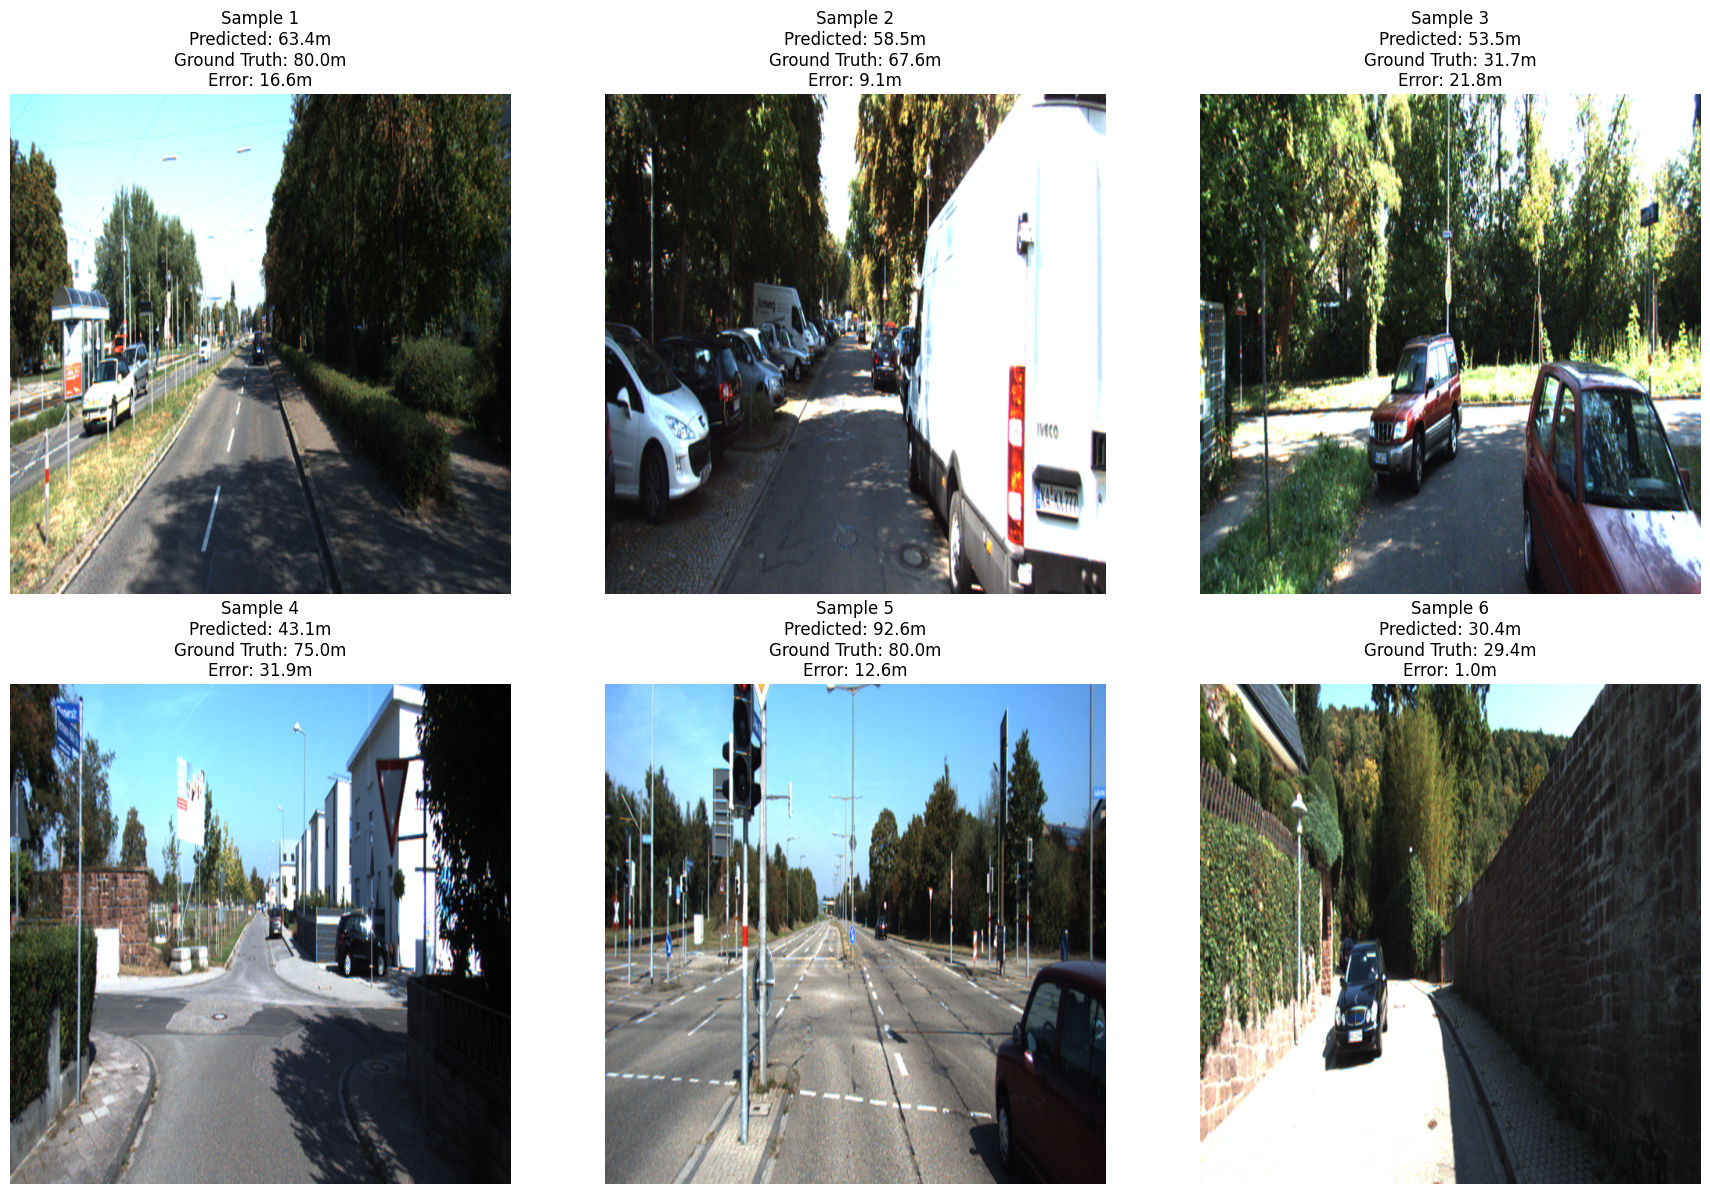


2. Running comprehensive evaluation:
Running comprehensive evaluation...


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Evaluation Results (n=200):
RMSE: 12.03m
MAE: 9.47m
MAPE: 18.0%
Median Error: 8.16m
R² Score: 0.682
Error Std: 12.03m

Distance Statistics:
Predicted range: 12.4m - 115.9m
Ground truth range: 15.1m - 80.0m
Mean predicted: 57.5m
Mean ground truth: 57.5m

Error Percentiles:
50th percentile: 8.16m
75th percentile: 13.28m
90th percentile: 18.85m
95th percentile: 24.03m
99th percentile: 33.59m

3. Creating detailed analysis plots:


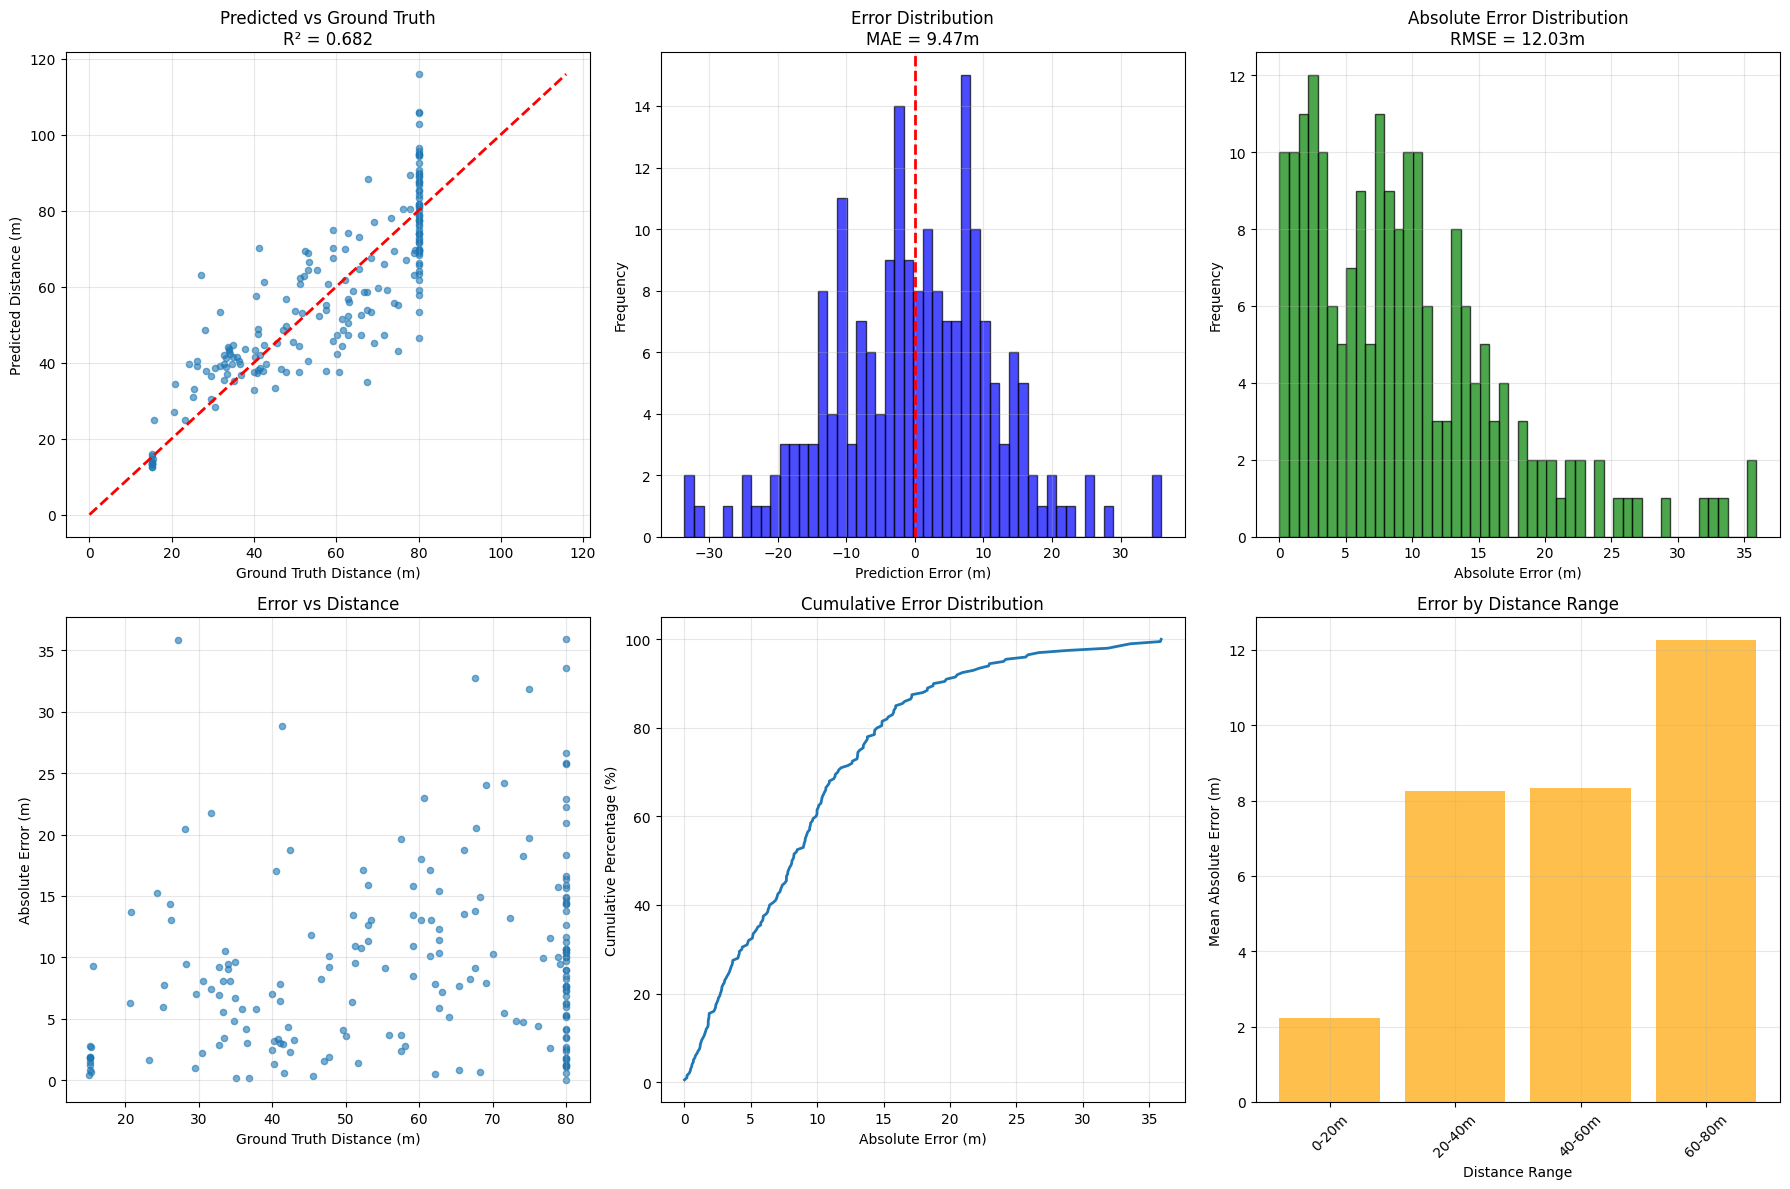


✓ Step 7 completed successfully!
✓ Model evaluation complete
✓ Final performance: RMSE=12.03m, MAE=9.47m, R²=0.682
✓ Model is ready for deployment!


In [10]:
# Step 7: Inference and Visualization

def load_best_model(model, checkpoint_path='yolov8_distance_best.pth'):
    """Load the best trained model"""

    print(f"Loading best model from {checkpoint_path}...")

    try:
        checkpoint = torch.load(checkpoint_path, map_location=config.device)
        model.load_state_dict(checkpoint['model_state_dict'])

        print(f"✓ Model loaded successfully!")
        print(f"✓ Trained for {checkpoint['epoch']+1} epochs")
        print(f"✓ Best validation loss: {checkpoint['val_loss']:.4f}")

        if 'metrics' in checkpoint and checkpoint['metrics']:
            metrics = checkpoint['metrics']
            print(f"✓ Final RMSE: {metrics.get('rmse', 0):.2f}m")
            print(f"✓ Final MAE: {metrics.get('mae', 0):.2f}m")
            print(f"✓ Final R²: {metrics.get('r2', 0):.3f}")

        return True

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return False

def predict_distances(model, images, device):
    """Predict distances for a batch of images"""

    # Set model to eval mode
    set_model_mode(model, training=False)

    with torch.no_grad():
        images = images.to(device)

        # Forward pass
        det_output, dist_outputs = model(images)

        # Extract distance predictions
        if dist_outputs and len(dist_outputs) > 0:
            # Average predictions from all scales
            global_dist_preds = []
            for dist_pred in dist_outputs:
                B = dist_pred.size(0)
                dist_pooled = torch.mean(dist_pred.view(B, -1), dim=1)
                global_dist_preds.append(dist_pooled)

            if global_dist_preds:
                avg_dist_pred = torch.stack(global_dist_preds).mean(dim=0)
                # Convert from log space to real distances
                distances = np.expm1(avg_dist_pred.cpu().numpy())
                return distances, det_output, dist_outputs

        return None, det_output, dist_outputs

def visualize_predictions(model, val_loader, device, num_samples=6):
    """Visualize model predictions on validation samples"""

    print(f"Visualizing {num_samples} prediction samples...")

    # Get sample batch
    sample_images, sample_labels, sample_distances, sample_global_depths = next(iter(val_loader))

    # Make predictions
    pred_distances, det_output, dist_outputs = predict_distances(model, sample_images, device)

    if pred_distances is None:
        print("❌ No distance predictions available")
        return

    # Convert ground truth from log space
    true_distances = np.expm1(sample_global_depths.cpu().numpy())

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Show sample predictions
    for i in range(min(num_samples, len(sample_images))):
        # Denormalize image for display
        img = sample_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(
            f'Sample {i+1}\n'
            f'Predicted: {pred_distances[i]:.1f}m\n'
            f'Ground Truth: {true_distances[i]:.1f}m\n'
            f'Error: {abs(pred_distances[i] - true_distances[i]):.1f}m',
            fontsize=12
        )
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_distances, true_distances

def evaluate_model_comprehensive(model, val_loader, device):
    """Comprehensive evaluation of the model"""

    print("Running comprehensive evaluation...")
    print("=" * 40)

    all_predictions = []
    all_ground_truths = []
    total_samples = 0

    # Set model to eval mode
    set_model_mode(model, training=False)

    progress_bar = tqdm(val_loader, desc="Evaluating")

    with torch.no_grad():
        for images, labels, distances, global_depths in progress_bar:
            # Predict distances
            pred_distances, _, _ = predict_distances(model, images, device)

            if pred_distances is not None:
                # Convert ground truth from log space
                true_distances = np.expm1(global_depths.cpu().numpy())

                all_predictions.extend(pred_distances)
                all_ground_truths.extend(true_distances)
                total_samples += len(pred_distances)

    # Calculate comprehensive metrics
    if len(all_predictions) > 0:
        predictions = np.array(all_predictions)
        ground_truths = np.array(all_ground_truths)

        # Basic metrics
        rmse = mean_squared_error(ground_truths, predictions) ** 0.5
        mae = mean_absolute_error(ground_truths, predictions)
        r2 = r2_score(ground_truths, predictions)

        # Additional metrics
        mape = np.mean(np.abs((ground_truths - predictions) / ground_truths)) * 100
        median_error = np.median(np.abs(predictions - ground_truths))
        std_error = np.std(predictions - ground_truths)

        # Distance range analysis
        errors = np.abs(predictions - ground_truths)

        print(f"Evaluation Results (n={total_samples}):")
        print(f"{'='*40}")
        print(f"RMSE: {rmse:.2f}m")
        print(f"MAE: {mae:.2f}m")
        print(f"MAPE: {mape:.1f}%")
        print(f"Median Error: {median_error:.2f}m")
        print(f"R² Score: {r2:.3f}")
        print(f"Error Std: {std_error:.2f}m")

        print(f"\nDistance Statistics:")
        print(f"Predicted range: {predictions.min():.1f}m - {predictions.max():.1f}m")
        print(f"Ground truth range: {ground_truths.min():.1f}m - {ground_truths.max():.1f}m")
        print(f"Mean predicted: {predictions.mean():.1f}m")
        print(f"Mean ground truth: {ground_truths.mean():.1f}m")

        # Error percentiles
        print(f"\nError Percentiles:")
        for p in [50, 75, 90, 95, 99]:
            print(f"{p}th percentile: {np.percentile(errors, p):.2f}m")

        return predictions, ground_truths, {
            'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape,
            'median_error': median_error, 'std_error': std_error
        }

    else:
        print("❌ No valid predictions for evaluation")
        return None, None, None

def plot_prediction_analysis(predictions, ground_truths, metrics):
    """Create detailed analysis plots"""

    if predictions is None or ground_truths is None:
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Scatter plot: Predicted vs Ground Truth
    axes[0, 0].scatter(ground_truths, predictions, alpha=0.6, s=20)
    axes[0, 0].plot([0, max(ground_truths.max(), predictions.max())],
                    [0, max(ground_truths.max(), predictions.max())], 'r--', linewidth=2)
    axes[0, 0].set_xlabel('Ground Truth Distance (m)')
    axes[0, 0].set_ylabel('Predicted Distance (m)')
    axes[0, 0].set_title(f'Predicted vs Ground Truth\nR² = {metrics["r2"]:.3f}')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Error distribution
    errors = predictions - ground_truths
    axes[0, 1].hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Prediction Error (m)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Error Distribution\nMAE = {metrics["mae"]:.2f}m')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Absolute error distribution
    abs_errors = np.abs(errors)
    axes[0, 2].hist(abs_errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 2].set_xlabel('Absolute Error (m)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Absolute Error Distribution\nRMSE = {metrics["rmse"]:.2f}m')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Error vs Ground Truth Distance
    axes[1, 0].scatter(ground_truths, abs_errors, alpha=0.6, s=20)
    axes[1, 0].set_xlabel('Ground Truth Distance (m)')
    axes[1, 0].set_ylabel('Absolute Error (m)')
    axes[1, 0].set_title('Error vs Distance')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Cumulative error distribution
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    axes[1, 1].plot(sorted_errors, cumulative, linewidth=2)
    axes[1, 1].set_xlabel('Absolute Error (m)')
    axes[1, 1].set_ylabel('Cumulative Percentage (%)')
    axes[1, 1].set_title('Cumulative Error Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Distance range analysis
    distance_ranges = [(0, 20), (20, 40), (40, 60), (60, 80)]
    range_errors = []
    range_labels = []

    for min_dist, max_dist in distance_ranges:
        mask = (ground_truths >= min_dist) & (ground_truths < max_dist)
        if mask.sum() > 0:
            range_error = np.mean(abs_errors[mask])
            range_errors.append(range_error)
            range_labels.append(f'{min_dist}-{max_dist}m')

    if range_errors:
        axes[1, 2].bar(range_labels, range_errors, alpha=0.7, color='orange')
        axes[1, 2].set_xlabel('Distance Range')
        axes[1, 2].set_ylabel('Mean Absolute Error (m)')
        axes[1, 2].set_title('Error by Distance Range')
        axes[1, 2].tick_params(axis='x', rotation=45)
        axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("YOLOv8 Distance Estimation - Step 7: Inference and Visualization")
    print("=" * 70)

    # Load the best trained model
    if load_best_model(model):

        # Visualize sample predictions
        print(f"\n1. Visualizing sample predictions:")
        pred_distances, true_distances = visualize_predictions(model, val_loader, config.device, num_samples=6)

        # Comprehensive evaluation
        print(f"\n2. Running comprehensive evaluation:")
        all_predictions, all_ground_truths, metrics = evaluate_model_comprehensive(model, val_loader, config.device)

        # Detailed analysis plots
        if metrics:
            print(f"\n3. Creating detailed analysis plots:")
            plot_prediction_analysis(all_predictions, all_ground_truths, metrics)

            print(f"\n✓ Step 7 completed successfully!")
            print(f"✓ Model evaluation complete")
            print(f"✓ Final performance: RMSE={metrics['rmse']:.2f}m, MAE={metrics['mae']:.2f}m, R²={metrics['r2']:.3f}")
            print(f"✓ Model is ready for deployment!")

    else:
        print("❌ Failed to load trained model. Please ensure training completed successfully.")